# Implement DCGAN 

In [1]:
import os
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt

In [2]:
dir = "E:/data/dcgan/img_align_celeba"

In [3]:
len(os.listdir(dir))

202599

In [6]:
img.shape

(218, 178, 3)

(-0.5, 177.5, 217.5, -0.5)

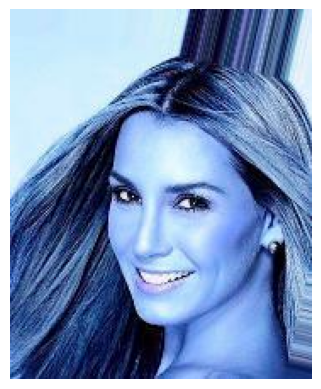

In [5]:
img = os.path.join(dir,os.listdir(dir)[0])
img = cv2.imread(img)
plt.imshow(img)
plt.axis('off')

In [7]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torchvision.utils import make_grid as make_grid
import torchvision.transforms as transforms

In [8]:
random.seed(999)
torch.manual_seed(999)

num_workers = 2
batch_size = 128
img_size = 64
num_epochs = 5
lr = 0.0002

In [9]:
# creater a dataset
dataset = dset.ImageFolder(root='E:/data/dcgan/',
                          transform=transforms.Compose([
                              transforms.Resize(img_size),
                              transforms.CenterCrop(img_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                          ]))

dataloder = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [10]:
device ='cuda' if torch.cuda.is_available else 'cpu'

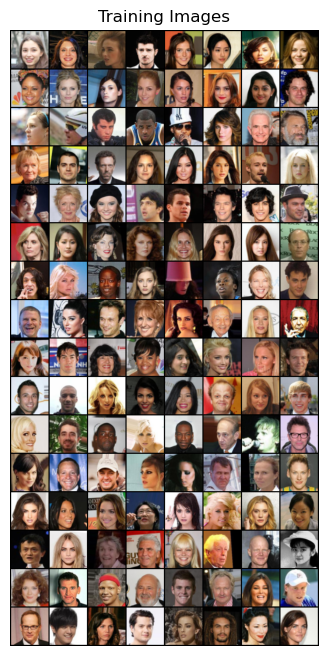

In [11]:
real_batch = next(iter(dataloder))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(make_grid(real_batch[0],padding=2,normalize=True),(1,2,0)))

![alt text](https://pytorch.org/tutorials/_images/dcgan_generator.png)

$$W_{out}=kernel\_size[1] + (W_{in} - 1)*stride[1] - 2*padding[1]$$
$$H_{out}=kernel\_size[0] + (H_{in} - 1)*stride[0] - 2*padding[0]$$

In [12]:
# Generator 

def BasicTransConv2d(in_channels,out_channels,ks,s,p):
    return nn.Sequential(nn.ConvTranspose2d(in_channels,out_channels,ks,s,p),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=True))

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(BasicTransConv2d(100,1024,4,1,0),#1-> 4
                                 BasicTransConv2d(1024,512,4,2,1), # 4 -> 8
                                 BasicTransConv2d(512,256,4,2,1), #8-> 16
                                 BasicTransConv2d(256,128,4,2,1), # 16 -> 32
                                 nn.ConvTranspose2d(128,3,4,2,1), # 32 -> 64
                                 nn.Tanh()
                                 )
    def forward(self,z):
        return self.main(z)

In [13]:
from torchinfo import summary
z = torch.ones((10,100,1,1))
gen = Generator()
summary(gen,input_data=z,device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [10, 3, 64, 64]           --
├─Sequential: 1-1                        [10, 3, 64, 64]           --
│    └─Sequential: 2-1                   [10, 1024, 4, 4]          --
│    │    └─ConvTranspose2d: 3-1         [10, 1024, 4, 4]          1,639,424
│    │    └─BatchNorm2d: 3-2             [10, 1024, 4, 4]          2,048
│    │    └─ReLU: 3-3                    [10, 1024, 4, 4]          --
│    └─Sequential: 2-2                   [10, 512, 8, 8]           --
│    │    └─ConvTranspose2d: 3-4         [10, 512, 8, 8]           8,389,120
│    │    └─BatchNorm2d: 3-5             [10, 512, 8, 8]           1,024
│    │    └─ReLU: 3-6                    [10, 512, 8, 8]           --
│    └─Sequential: 2-3                   [10, 256, 16, 16]         --
│    │    └─ConvTranspose2d: 3-7         [10, 256, 16, 16]         2,097,408
│    │    └─BatchNorm2d: 3-8             [10, 256, 16, 16]

In [14]:
# Discriminator

def BasicConv2d(in_channels,out_channels,ks,s,p):
    return nn.Sequential(nn.Conv2d(in_channels,out_channels,ks,s,p,bias=False),
                        nn.BatchNorm2d(out_channels),
                        nn.LeakyReLU(0.2,inplace=True))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(BasicConv2d(3,128,3,2,1),
                                 BasicConv2d(128,256,3,2,1),
                                 BasicConv2d(256,512,3,2,1),
                                 BasicConv2d(512,1024,3,2,1),
                                 nn.Conv2d(1024,1,3,2,0),
                                 nn.Sigmoid()
                                 )
        
    def forward(self,gz):
        return self.main(gz)

In [15]:
data = torch.ones((10,3,64,64))
disc = Discriminator()
summary(disc,input_data=data,device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [10, 1, 1, 1]             --
├─Sequential: 1-1                        [10, 1, 1, 1]             --
│    └─Sequential: 2-1                   [10, 128, 32, 32]         --
│    │    └─Conv2d: 3-1                  [10, 128, 32, 32]         3,456
│    │    └─BatchNorm2d: 3-2             [10, 128, 32, 32]         256
│    │    └─LeakyReLU: 3-3               [10, 128, 32, 32]         --
│    └─Sequential: 2-2                   [10, 256, 16, 16]         --
│    │    └─Conv2d: 3-4                  [10, 256, 16, 16]         294,912
│    │    └─BatchNorm2d: 3-5             [10, 256, 16, 16]         512
│    │    └─LeakyReLU: 3-6               [10, 256, 16, 16]         --
│    └─Sequential: 2-3                   [10, 512, 8, 8]           --
│    │    └─Conv2d: 3-7                  [10, 512, 8, 8]           1,179,648
│    │    └─BatchNorm2d: 3-8             [10, 512, 8, 8]           1

In [16]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

In [17]:
# Training Loop

disc = disc.to(device)
gen = gen.to(device)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloder, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        disc.zero_grad()
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = disc(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloder),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloder)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.3274	Loss_G: 4.2240	D(x): 0.5468	D(G(z)): 0.5033 / 0.0157
[0/5][50/1583]	Loss_D: 0.4306	Loss_G: 17.3235	D(x): 0.7762	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.0597	Loss_G: 7.5305	D(x): 0.9886	D(G(z)): 0.0466 / 0.0005
[0/5][150/1583]	Loss_D: 0.4371	Loss_G: 6.0396	D(x): 0.7789	D(G(z)): 0.0667 / 0.0063
[0/5][200/1583]	Loss_D: 0.9704	Loss_G: 1.5471	D(x): 0.5785	D(G(z)): 0.1870 / 0.2715
[0/5][250/1583]	Loss_D: 0.7498	Loss_G: 2.0227	D(x): 0.6207	D(G(z)): 0.1663 / 0.1686
[0/5][300/1583]	Loss_D: 0.4658	Loss_G: 3.1769	D(x): 0.9206	D(G(z)): 0.2967 / 0.0624
[0/5][350/1583]	Loss_D: 0.5547	Loss_G: 2.3788	D(x): 0.7264	D(G(z)): 0.1785 / 0.1157
[0/5][400/1583]	Loss_D: 2.7681	Loss_G: 3.5090	D(x): 0.1362	D(G(z)): 0.0069 / 0.0487
[0/5][450/1583]	Loss_D: 0.4508	Loss_G: 2.8810	D(x): 0.7847	D(G(z)): 0.1546 / 0.0687
[0/5][500/1583]	Loss_D: 0.7567	Loss_G: 2.0407	D(x): 0.5556	D(G(z)): 0.0655 / 0.1518
[0/5][550/1583]	Loss_D: 0.7153	Loss_G: 4.9456	D(x): 

[3/5][50/1583]	Loss_D: 0.3577	Loss_G: 4.5628	D(x): 0.9265	D(G(z)): 0.2297 / 0.0140
[3/5][100/1583]	Loss_D: 0.7074	Loss_G: 1.0741	D(x): 0.5672	D(G(z)): 0.0433 / 0.3898
[3/5][150/1583]	Loss_D: 0.3057	Loss_G: 2.6697	D(x): 0.8364	D(G(z)): 0.1084 / 0.0829
[3/5][200/1583]	Loss_D: 0.3877	Loss_G: 2.6301	D(x): 0.7982	D(G(z)): 0.1299 / 0.0867
[3/5][250/1583]	Loss_D: 0.6630	Loss_G: 4.4076	D(x): 0.9656	D(G(z)): 0.4303 / 0.0157
[3/5][300/1583]	Loss_D: 0.4212	Loss_G: 2.9314	D(x): 0.6984	D(G(z)): 0.0269 / 0.0700
[3/5][350/1583]	Loss_D: 0.2818	Loss_G: 3.7303	D(x): 0.9277	D(G(z)): 0.1800 / 0.0277
[3/5][400/1583]	Loss_D: 0.3892	Loss_G: 3.4071	D(x): 0.8412	D(G(z)): 0.1782 / 0.0396
[3/5][450/1583]	Loss_D: 0.8301	Loss_G: 2.0647	D(x): 0.5938	D(G(z)): 0.1881 / 0.1827
[3/5][500/1583]	Loss_D: 0.3512	Loss_G: 2.9552	D(x): 0.8035	D(G(z)): 0.1036 / 0.0711
[3/5][550/1583]	Loss_D: 0.3325	Loss_G: 4.2173	D(x): 0.9276	D(G(z)): 0.2080 / 0.0200
[3/5][600/1583]	Loss_D: 0.7396	Loss_G: 2.1468	D(x): 0.5666	D(G(z)): 0.0634 / 

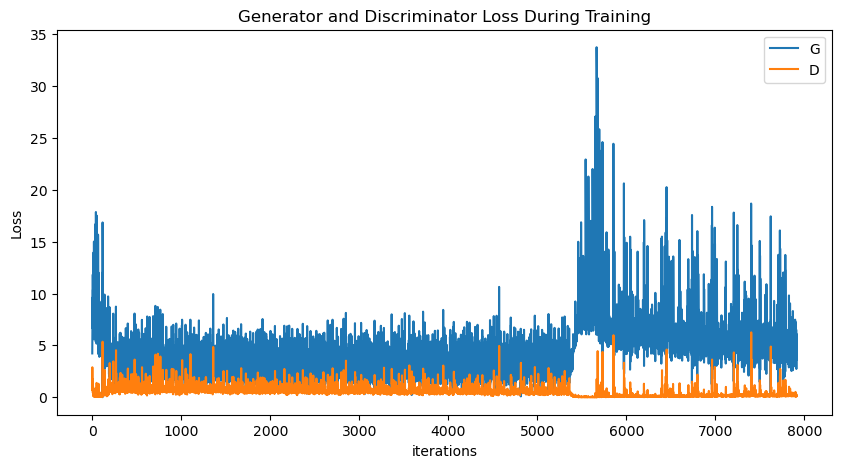

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

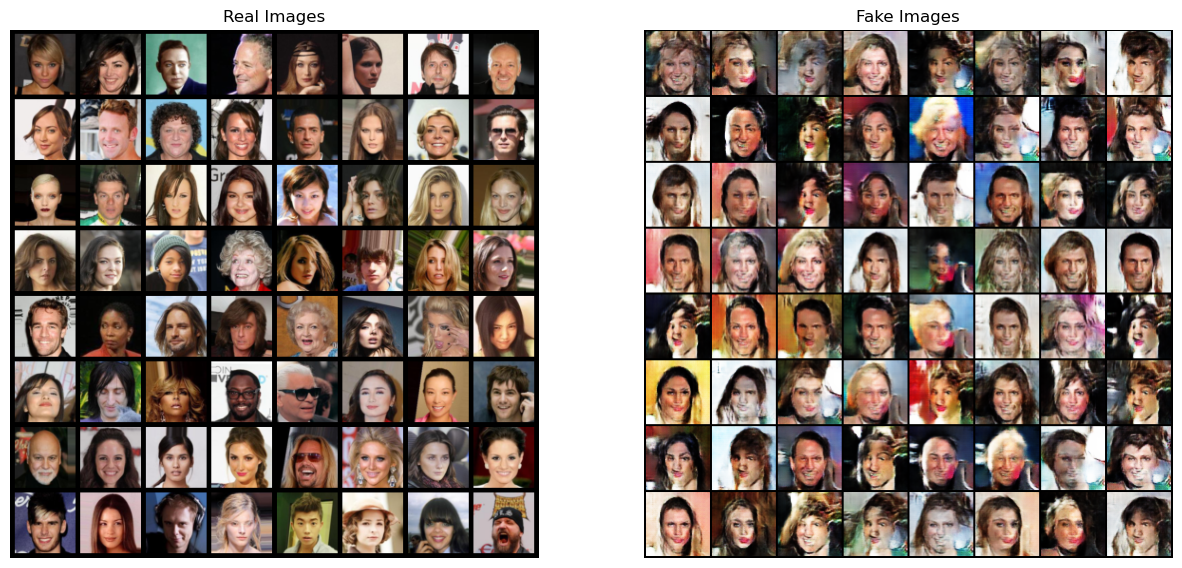

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloder))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
plt.show()